Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
NAME = "Win Win Phyo"
ID = "st122314"

---

# Lab 12: Gaussian Mixture Models (GMMs)

Today we continue with unsupervised learning. One model that's more sophisticated than $k$-means is the Gaussian Mixture Model (GMM).

The GMM models a dataset $(\mathbf{x}^{(1)},\ldots,\mathbf{x}^{(m)})$ as an i.i.d. sample from the following
generative model for each sample
$\mathbf{x}^{(i)}$:

1. Sample $z^{(i)}$ from a multinomial distribution over clusters $1..k$ according to probabilities $(\phi_1,\ldots,\phi_k)$.
2. Sample $\mathbf{x}^{(i)}$ from ${\cal N}(\mathbf{\mu}_{z^{(i)}},\Sigma_{z^{(i)}})$.

The parameters are estimated using the Expectation Maximization (EM) algorithm, which begins with a guess for parameters
$\phi_1,\ldots,\phi_k,\mu_1,\ldots,\mu_k,\Sigma_1,\ldots,\Sigma_k$ then iteratively alternates between computing a soft assignment
of data to clusters then updating the parameters according to that soft assignment.

First, we'll build a GMM model for a dataset then use the model for anomaly detection.

## Example 1: Anomaly detection

Let's generate synthetic data from a mixture of Gaussians, use EM to recover as best possible the ground truth parameters, and
then use the model to find "anomalies" (unusually unlikely points according to the model). First, we set up the ground truth
parameters and generate a dataset from those ground truth parameters:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# Ground truth means and covariances for the data we'll generate

means_gt = [ [1,10], [10,1], [10,10] ]
sigmas_gt = [ np.matrix([[1, 0],[0, 1]]), np.matrix([[4,0],[0,1]]),
              np.matrix([[1,0],[0,4]]) ]

# Ground truth Prior probability (phi_j) for each cluster

phi_gt = [ 0.2, 0.2, 0.6 ]

# For more interesting covariances, you can also try, for example,
# [[11.31371, -0.70711],[11.31371, 0.70711]] or
# [[11.31371, 0.70711],[-11.31371, 0.70711]].

# Size of dataset

m = 500

# number of variables

n = len(means_gt[0])

# k number of clusters/outcomes

k = len(phi_gt)

# Ground truth indices of cluster identities

Z = [0]*m

# Generate a new k-means dataset

def gen_dataset():
    X = np.zeros((m,n))
    # Generate m samples from multinomial distribution using phi_gt
    z_vectors = np.random.multinomial(1, phi_gt, size=m)  # Result: binary matrix of size (m x k)
    for i in range(m):
        # Convert one-hot representation z_vectors[i,:] to an index
        Z[i] = np.where(z_vectors[i,:] == 1)[0][0]
        # Grab ground truth mean mu_{z^i}
        mu = means_gt[Z[i]]                
        # Grab ground truth covariance Sigma_{z^i}
        sigma = sigmas_gt[Z[i]]
        # Sample a 2D point from mu, sigma
        X[i,:] = np.random.multivariate_normal(mu,sigma,1)
    return X


X = gen_dataset()

Next, the EM algorithm itself. We have an initialization step and an iterative step.

In [3]:
def init_gmm(X, k):
    m = X.shape[0]
    n = X.shape[1]
    Mu = np.zeros((n,k))
    Sigma = np.zeros((k,n,n))
    Phi = np.zeros(k)
    order = np.random.permutation(m)
    for j in range(k):
        # Initially assign equal probability to each cluster/outcome
        Phi[j] = 1/k      
        # Ramdomly assign mean to one of the data points       
        Mu[:,j] = X[order[j],:].T
        # Initial covariance is identity matrix
        Sigma[j,:,:] = np.eye(n)    
    return Phi, Mu, Sigma


def Gaussian(X, mean, covariance):
    k = len(mean)
    X = X - mean.T
    p = 1/((2*np.pi)**(k/2)*(np.linalg.det(covariance)**0.5)) * np.exp(-0.5 * np.sum(X @ np.linalg.pinv(covariance) * X, axis=1))
    return p

def gaussian(x, mean,covariance):
    k = len(mean)
    X = (x - mean).reshape(-1,1)
    p = 1/((2*np.pi)**(k/2)*(np.linalg.det(covariance)**0.5)) * np.exp(-0.5 * (X.T @ np.linalg.pinv(covariance) @ X))
    return p


# Run one iteration of EM

def iterate_em_gmm(X, threshold, Phi, Mu, Sigma):
    m = X.shape[0]
    n = X.shape[1]
    k = len(Phi)
    threshold = np.reshape(np.repeat(threshold, n*k), (n,k))
    pj_arr = np.zeros((m,k))
    
    # E-step: calculate w_j^i
    W = np.zeros((m, k))
    for j in range(k):
        pj = Gaussian(X, Mu[:,j], Sigma[j])
        pj_arr[:,j] = pj
        W[:,j] = Phi[j] * pj
    
    # W tells us what is the relative weight of each cluster for each data point
    W[:,:] = W * np.tile(1/np.sum(W,1),(k,1)).T

    # M-step: adjust mean and sigma
    Phi[:] = sum(W) / m
    Mu_previous = Mu.copy()
    for j in range(k):
        # Split cluster specific W for each dimension
        Wj = np.tile(W[:,j],(2,1)).T
        # Compute Mu for each variable for each cluster
        Mu[:,j] = sum(X * Wj)/sum(Wj)
        Muj = np.tile(Mu[:,j],(m,1))
        Sigma[j,:,:] = np.matmul((X - Muj).T, (X - Muj) * Wj) / sum(W[:,j])

    if (abs(Mu-Mu_previous) <= threshold).all():
        converged = True
    else:
        converged = False

    labels = np.argmax(pj_arr, axis = 1)
    pj = np.max(pj_arr,axis=1)
    X_label = np.insert(X, 2, labels, axis=1)
    return converged, pj, X_label

Let's run the model to convergence:

In [4]:
threshold = np.matrix(.01)

Phi, Mu, Sigma = init_gmm(X, k)

converged = False
while not converged:
    converged, pj, X_label = iterate_em_gmm(X, threshold, Phi, Mu, Sigma)

In [5]:
print(Phi)
print(phi_gt)

phi_gt = np.array(phi_gt).reshape(-1,1)
phi_mse = np.mean(np.min((Phi-phi_gt)**2,axis=1))

print(phi_mse)

[0.16400002 0.64424497 0.19175501]
[0.2, 0.2, 0.6]
0.0006978590993098514


In [6]:
print(Mu)
print(np.array(means_gt).T)

[[ 1.14783307  9.93995463  9.9957218 ]
 [ 9.92654716 10.02418869  1.03534822]]
[[ 1 10 10]
 [10  1 10]]


In [7]:
print(Sigma)
print(sigmas_gt)

[[[1.00658384 0.18855439]
  [0.18855439 0.89438818]]

 [[1.01231077 0.151149  ]
  [0.151149   4.26391811]]

 [[3.47754992 0.25084507]
  [0.25084507 0.79729183]]]
[matrix([[1, 0],
        [0, 1]]), matrix([[4, 0],
        [0, 1]]), matrix([[1, 0],
        [0, 4]])]


### In-class exercise (not graded, for practice)

Determine how close the estimated parmeters Phi, Mu, and Sigma are to the ground trouth values set up at the beginning of the experiment. Report your results and briefly discuss here.

Next, we continue to find outliers:

In [8]:
outlier_prob = .01
outliers = np.nonzero(pj < outlier_prob)[0]

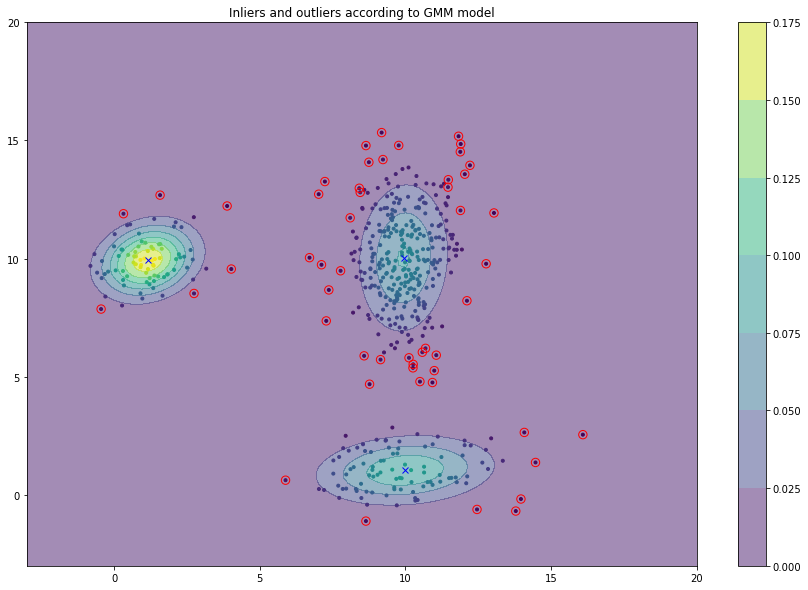

In [9]:
fig1 = plt.figure(figsize=(15,10))

xlist = np.linspace(-3, 20, 100)
ylist = np.linspace(-3, 20, 100)
XX, YY = np.meshgrid(xlist, ylist)
ZZ = np.zeros(XX.shape)

for c in np.arange(0,k):    
    X_class = X[np.where(X_label[:,2] == c)[0],:]
    
    Z = np.zeros(XX.shape)
    i = 0
    while i < XX.shape[0]:
        j = 0
        while j < XX.shape[0]:
            pt = np.array([[XX[i,j], YY[i,j]]])
            Z[i,j] = Gaussian(pt, Mu[:,c], Sigma[c])[0]
            j = j + 1
        i = i + 1    
    ZZ = np.maximum(ZZ,Z)
cp = plt.contourf(XX, YY, ZZ,alpha=0.5)
cbar = fig1.colorbar(cp)

plt.scatter(X[:,0],X[:,1],marker=".",c=pj,cmap='viridis');
plt.scatter(X[outliers,0],X[outliers,1],marker="o",facecolor="none",edgecolor="r",s=70);
plt.plot(Mu[0,0], Mu[1,0],'bx',Mu[0,1], Mu[1,1],'bx', Mu[0,2], Mu[1,2],'bx')

plt.title('Inliers and outliers according to GMM model')
plt.show()

### In-class exercise

Notice that using a hard threshold for each cluster gives us more outliers for a broad cluster than a
tight cluster. First, you'll want to understand why and explain.  Next, you'll read about
Mahalanobis distance
of a point to the mean of a multivariate Gaussian distribution and see if you can use Mahalanobis distance
to get a better notion of outliers in this dataset.

### Exercise 1.1 (10 points)

Notice that using a hard threshold for each cluster gives us more outliers for a broad cluster than a tight cluster. Understand why, and explain here.

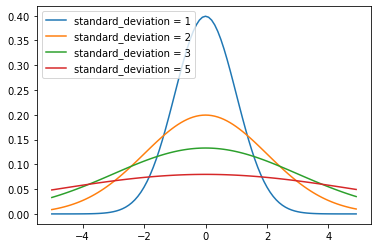

In [10]:
# You may need code to explain
from scipy.stats import chi2
import matplotlib.pyplot as plt
import numpy as np
import scipy
import math

mean = 0
standard_deviation = 1

x_values = np.arange(-5, 5, 0.1)
y_values1 = scipy.stats.norm(mean, standard_deviation)
y_values2 = scipy.stats.norm(mean, 2)
y_values3 = scipy.stats.norm(mean, 3)
y_values4 = scipy.stats.norm(mean, 5)
plt.plot(x_values, y_values1.pdf(x_values),label = 'standard_deviation = 1')
plt.plot(x_values, y_values2.pdf(x_values),label = 'standard_deviation = 2')
plt.plot(x_values, y_values3.pdf(x_values),label = 'standard_deviation = 3')
plt.plot(x_values, y_values4.pdf(x_values),label = 'standard_deviation = 5')
plt.legend()
plt.show()

In [11]:
# # You may need code to explain

# import numpy as np
# import pandas as pd 
# import scipy as stats

# df = pd.DataFrame(X,columns=['X1', 'X2'])
# df.head()

# def mahalanobis(x=None, data=None, cov=None):

#     x_mu = x - np.mean(data)
#     if not cov:
#         cov = np.cov(data.values.T)
#     inv_covmat = np.linalg.inv(cov)
#     left = np.dot(x_mu, inv_covmat)
#     mahal = np.dot(left, x_mu.T)
#     return mahal.diagonal()

# df['mahalanobis'] = mahalanobis(x=df, data=df[['X1', 'X2']])

# # print(np.min(df['mahalanobis']))
# df.head()

In [12]:
# from scipy.stats import chi2

# #calculate p-value for each mahalanobis distance 
# df['p'] = 1 - chi2.cdf(df['mahalanobis'], 3)

# #display p-values for first five rows in dataframe
# df.head()

In [13]:
# mahalanobis = df['p'] < 0.15
# plt.figure(figsize=(10,6))
# plt.scatter(X[:,0],X[:,1],marker=".",c=pj,cmap='viridis');
# plt.scatter(X[mahalanobis,0],X[mahalanobis,1],marker="o",facecolor="none",edgecolor="r",s=70);
# plt.plot(Mu[0,0], Mu[1,0],'bx',Mu[0,1], Mu[1,1],'bx', Mu[0,2], Mu[1,2],'bx')

# for c in np.arange(0,k):    
#     X_class = X[np.where(X_label[:,2] == c)[0],:]
#     xlist = np.linspace(min(X_class[:,0]), max(X_class[:,0]), 30)
#     ylist = np.linspace(min(X_class[:,1]), max(X_class[:,1]), 30)
    
#     XX, YY = np.meshgrid(xlist, ylist)
#     Z = np.zeros(XX.shape)
#     i = 0
#     while i < XX.shape[0]:
#         j = 0
#         while j < XX.shape[0]:
#             pt = np.array([[XX[i,j], YY[i,j]]])
#             Z[i,j] = Gaussian(pt, Mu[:,c], Sigma[c])[0]
#             j = j + 1
#         i = i + 1    
#     cp = plt.contour(XX, YY, Z)
# plt.title('Inliers and outliers according to GMM model')
# plt.show()

As the width of a Gaussian increases, it height necessarily decreases and we got a broad cluster and give more
outliers. But on the other hand, as the width of a Gaussian decreases, it height increase and we got a tight
cluster and give less outliers.

YOUR ANSWER HERE

Using a hard threshold for each cluster gives us more outliers for a broad cluster than a tight cluster. 

There are 2 effects.

1.Probability densities of different variances will result in having different thresholds for any arbitrary p value. A high variance will flatten and lower the normal curve, therefore, will have a lower threshold for a particular p value compared to a low variance distribution.
this is the reason why the broader cluster has more outliers when using the same threshold value for different clusters.

2.A broad cluster will take in more of the effects from the other clusters from the "w" in comparison to a tight cluster. This is because the likelihood of a datapoint from a different cluster in a tight cluster will have an extremely low value which the likelihood of a datapoint from a different cluster in a broad cluster will have a relatively larger value. Thus further increasing in variance.

### Exercise 1.2 (15 points)

Read about Mahalanobis distance of a point to the mean of a multivariate Gaussian distribution and see if you can use Mahalanobis distance to get a better notion of outliers in this dataset.
1. Explain what is Mahalanobis (5 points)
2. Write code Mahalanobis (10 points)

#### Explain what is Mahalanobis distance (5 points)

YOUR ANSWER HERE

Mahalanobis Distance is the distance between two points which has been scaled by the eigen vectors and values of the covariance matrix. In essence, it's like transforming all the points so that the distribution becomes a standard normal distributions, then finding the length from the transformed points.

The distance is a better way to find outliers because it aligns correctly with how z-scores work in gaussian distributions.



#### Write code to compute Mahalanobis distance between the data and their nearest means (10 points)

In [14]:
import sys
from scipy.stats import chi2
#np.set_printoptions(threshold=sys.maxsize)

print(Sigma.shape)
print(Mu.shape)
print(X.shape)

m_distance = np.zeros((X.shape[0],Mu.shape[1]))

for kk in range(Mu.shape[1]):
    for i, x in enumerate(X):
        
        # get all row data from target column
        mu = Mu[:, kk]
        
        # get target sigma
        sig = Sigma[kk, :, :]
        
        # inverse matrix of sigma
        sig_inv = np.linalg.inv(sig)
        
        # find difference of mu and x and reshape it (if need)
        diff = x - mu
        
        # calculate distance from diff and sigma
        distance = diff.dot(sig_inv).dot(diff.T)
        
        # YOUR CODE HERE
        #raise NotImplementedError()
        # keep distance
        m_distance[i,kk] = distance

# find unique of minimum m_distance and count
# hint: use np.unique and np.argmin
(unique, counts) = None, None

max_z_score = 2.05
# find minimum distance

# hint: use np.min
min_distance = np.min(m_distance, axis = 1)

# find outlier from min_distance
p = 1 - chi2.cdf(min_distance , 3)
outlier = np.nonzero(p < max_z_score)[0]
# YOUR CODE HERE
#raise NotImplementedError()

(3, 2, 2)
(2, 3)
(500, 2)


outlier [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 24

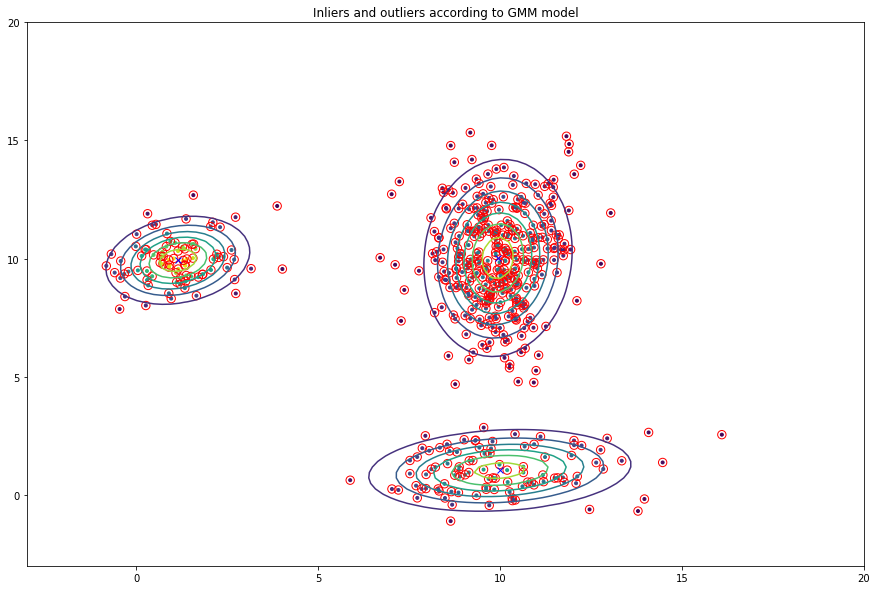

success!


In [15]:
# Test function: Do not remove
print('outlier', outlier)

fig1 = plt.figure(figsize=(15,10))

xlist = np.linspace(-3, 20, 100)
ylist = np.linspace(-3, 20, 100)
XX, YY = np.meshgrid(xlist, ylist)
ZZ = np.zeros(XX.shape)

for c in np.arange(0,k):    
    X_class = X[np.where(X_label[:,2] == c)[0],:]
    
    Z = np.zeros(XX.shape)
    i = 0
    while i < XX.shape[0]:
        j = 0
        while j < XX.shape[0]:
            pt = np.array([[XX[i,j], YY[i,j]]])
            Z[i,j] = Gaussian(pt, Mu[:,c], Sigma[c])[0]
            j = j + 1
        i = i + 1    
    cp = plt.contour(XX,YY,Z)

plt.scatter(X[:,0],X[:,1],marker=".",c=pj,cmap='viridis');
plt.scatter(X[outlier,0],X[outlier,1],marker="o",facecolor="none",edgecolor="r",s=70);
plt.plot(Mu[0,0], Mu[1,0],'bx',Mu[0,1], Mu[1,1],'bx', Mu[0,2], Mu[1,2],'bx')

plt.title('Inliers and outliers according to GMM model')
plt.show()
print('success!')
# End test function

## Example 2: Customer segmentation

In this example we will use the Kaggle customer segmentation dataset
from last week. We've included the
[Mall_Customers.csv](https://www.kaggle.com/vjchoudhary7/customer-segmentation-tutorial-in-python)
file with this lab.

Let's stick to just two dimensions in the dataset:

In [16]:
data = pd.read_csv('Mall_Customers.csv')
data = data.drop(['CustomerID', 'Gender', 'Age'], axis = 1)
print(data.head())

   Annual Income (k$)  Spending Score (1-100)
0                  15                      39
1                  15                      81
2                  16                       6
3                  16                      77
4                  17                      40


In [17]:
X  = np.array(data, dtype=float)

n = X.shape[1]
m = X.shape[0]
k = 3

threshold = np.matrix(.01)

# Slightly different version of init_gmm due to the data format and spread
def init_gmm(X, k):
    Mu = np.zeros((n,k))
    Sigma = np.zeros((k,n,n))
    Phi = np.zeros(k)
    order = np.random.permutation(m)
    for j in range(k):
        Phi[j] = 1/k
        Mu[:,j] = X[order[j],:].T
        Sigma[j,:,:] = np.cov(X.T)
    return Phi, Mu, Sigma


Phi, Mu, Sigma = init_gmm(X, k)

converged = False
while not converged:
    converged, pj, X_label = iterate_em_gmm(X, threshold, Phi, Mu, Sigma)

In [18]:
print(Mu)

[[51.1248689  60.69382066 85.64156272]
 [53.83822032 19.19209731 82.11210539]]


The first row represents annual income, whereas the second row represents the spending score. These values tend to change in every iteration, so therefore it is difficult to definitively segregate the data into three categories.

In [19]:
print(Sigma.shape)
print(Mu.shape)

(3, 2, 2)
(2, 3)


Next, the visualization:

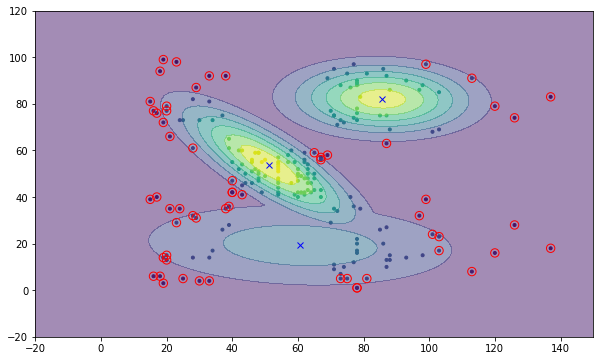

In [20]:
plt.figure(figsize=(10,6))
plt.scatter(X[:,0],X[:,1],marker=".",c=pj,cmap='viridis');

outlier_prob = .0002
outliers = np.nonzero(pj<outlier_prob)[0]


xlist = np.linspace(-20, 150, 100)
ylist = np.linspace(-20, 120, 100)
XX, YY = np.meshgrid(xlist, ylist)
ZZ = np.zeros(XX.shape)
for c in np.arange(0,k):    
    X_class = X[np.where(X_label[:,2] == c)[0],:]
    Z = np.zeros(XX.shape)
    i = 0
    while i < XX.shape[0]:
        j = 0
        while j < XX.shape[0]:
            pt = np.array([[XX[i,j], YY[i,j]]])
            Z[i,j] = Gaussian(pt, Mu[:,c], Sigma[c])
            j = j + 1
        i = i + 1    
    ZZ = np.maximum(ZZ,Z)
cp = plt.contourf(XX, YY, ZZ,alpha=0.5)
plt.scatter(X[outliers,0],X[outliers,1],marker="o",facecolor="none",edgecolor="r",s=70);
plt.plot(Mu[0,0], Mu[1,0],'bx',Mu[0,1], Mu[1,1],'bx', Mu[0,2], Mu[1,2],'bx')

plt.show()

### In-class exercise (25 points)

Examine the cluster centers and determine whether you can find any reasonable interpretation of them.
Discuss in your report (5 points), and compare to the $k$-means method from last week. (20 points)

#### Interpretation of clusters (5 points)

YOUR ANSWER HERE

Cluster 1: Average income, average expenditure

Cluster 2: High income , low expenditure

Cluster3: Low income, high expenditure

#### Run $k$-means and compare results

In [21]:
# YOUR CODE HERE
#raise NotImplementedError()


# Initialize a k-means model given a dataset
df = pd.read_csv("Mall_Customers.csv")

def init_kmeans(X, k):
    m = X.shape[0]
    n = X.shape[1]
    means = np.zeros((k,n))
    order = np.random.permutation(m)[:k]
    for i in range(k):
        means[i,:] = X[order[i],:]
    return means

# Run one iteration of k-means

def iterate_kmeans(X, means):
    m = X.shape[0]
    n = X.shape[1]
    k = means.shape[0]
    distortion = np.zeros(m)
    c = np.zeros(m)
    for i in range(m):
        min_j = 0
        min_dist = 0
        for j in range(k):
            dist_j = np.linalg.norm(X[i,:] - means[j,:])
            if dist_j < min_dist or j == 0:
                min_dist = dist_j
                min_j = j
        distortion[i] = min_dist
        c[i] = min_j
    for j in range(k):
        means[j,:] = np.zeros((1,n))
        nj = 0
        for i in range(m):
            if c[i] == j:
                nj = nj + 1
                means[j,:] = means[j,:] + X[i,:]
        if nj > 0:
            means[j,:] = means[j,:] / nj
    return means, c, np.sum(distortion)

#raise NotImplementedError()

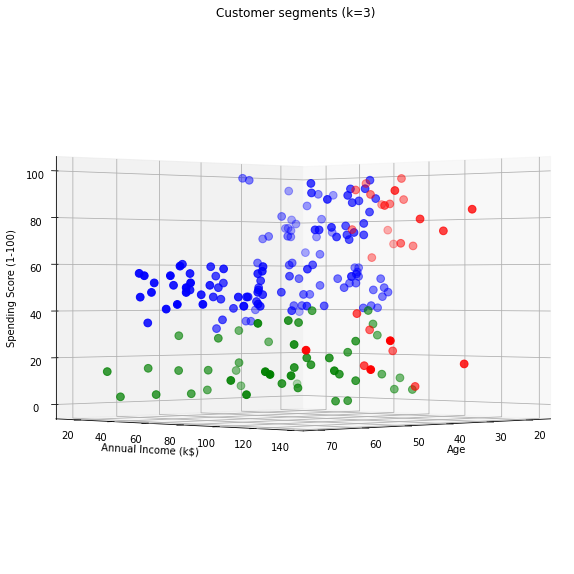

In [22]:
k = 3
means = init_kmeans(X, k)
epsilon = 0.001
prev_distortion = 0
while True:
    means, c, distortion = iterate_kmeans(X, means)
    if prev_distortion > 0 and prev_distortion - distortion < epsilon:
        break
    prev_distortion = distortion
    
# Set labels in dataset to cluster IDs according to k-means model.

df["label"] = c

# Plot the data

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df.Age[df.label == 0], df["Annual Income (k$)"][df.label == 0], df["Spending Score (1-100)"][df.label == 0], c='blue', s=60)
ax.scatter(df.Age[df.label == 1], df["Annual Income (k$)"][df.label == 1], df["Spending Score (1-100)"][df.label == 1], c='red', s=60)
ax.scatter(df.Age[df.label == 2], df["Annual Income (k$)"][df.label == 2], df["Spending Score (1-100)"][df.label == 2], c='green', s=60)

# For 5 clusters, you can uncomment the following two lines.

ax.scatter(df.Age[df.label == 3], df["Annual Income (k$)"][df.label == 3], df["Spending Score (1-100)"][df.label == 3], c='orange', s=60)
ax.scatter(df.Age[df.label == 4], df["Annual Income (k$)"][df.label == 4], df["Spending Score (1-100)"][df.label == 4], c='purple', s=60)

ax.view_init(0, 45)
plt.xlabel("Age")
plt.ylabel("Annual Income (k$)")
ax.set_zlabel('Spending Score (1-100)')
plt.title('Customer segments (k=3)')
plt.show()

### In-class exercise (10 points)

Do the same analysis with Mahalanobis distance as in the first example.

In [23]:
import sys
#np.set_printoptions(threshold=sys.maxsize)



print(Sigma.shape)
print(Mu.shape)
print(X.shape)

m_distance = np.zeros((X.shape[0],Mu.shape[1]))

for kk in range(Mu.shape[1]):
    for i, x in enumerate(X):
        
        # get all row data from target column
        mu = Mu[:, kk]
        
        # get target sigma
        sig = Sigma[kk, :, :]
        
        # inverse matrix of sigma
        sig_inv = np.linalg.inv(sig)
        
        # find difference of mu and x and reshape it (if need)
        diff = x - mu
        
        # calculate distance from diff and sigma
        distance = diff.dot(sig_inv).dot(diff.T)
        
        # YOUR CODE HERE
        #raise NotImplementedError()
        # keep distance
        m_distance[i,kk] = distance

# find unique of minimum m_distance and count
# hint: use np.unique and np.argmin
(unique, counts) = None, None

max_z_score = 2.05
# find minimum distance

# hint: use np.min
min_distance = np.min(m_distance, axis = 1)

# find outlier from min_distance
p = 1 - chi2.cdf(min_distance , 3)
outlier = np.nonzero(p < max_z_score)[0]
# YOUR CODE HERE
#raise NotImplementedError()

#outlier = None
# YOUR CODE HERE
#raise NotImplementedError()

(3, 2, 2)
(2, 3)
(200, 2)


outlier [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199]


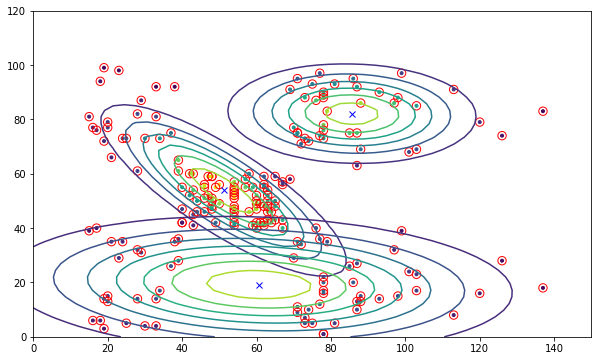

success!


In [24]:
# Test function: Do not remove
print('outlier', outlier)

plt.figure(figsize=(10,6))
plt.scatter(X[:,0],X[:,1],marker=".",c=pj,cmap='viridis');

plt.scatter(X[outlier,0],X[outlier,1],marker="o",facecolor="none",edgecolor="r",s=70);
plt.plot(Mu[0,0], Mu[1,0],'bx',Mu[0,1], Mu[1,1],'bx', Mu[0,2], Mu[1,2],'bx')

for c in np.arange(0,k):    
    X_class = X[np.where(X_label[:,2] == c)[0],:]
    xlist = np.linspace(0, 150, 50)
    ylist = np.linspace(0, 120, 50)
    
    XX, YY = np.meshgrid(xlist, ylist)
    Z = np.zeros(XX.shape)
    i = 0
    while i < XX.shape[0]:
        j = 0
        while j < XX.shape[0]:
            pt = np.array([[XX[i,j], YY[i,j]]])
            Z[i,j] = Gaussian(pt, Mu[:,c], Sigma[c])
            j = j + 1
        i = i + 1    
    cp = plt.contour(XX, YY, Z)

plt.show()
print('success!')
# End test function

### Example 3: Customer segmentation

This example is based on [Nguyen Hanh's tutorial on Medium.com](https://medium.com/@nguyenbaha/buiding-customer-segmentation-by-gmm-from-scratch-4ea6adc3da1c). In this example we use the Kaggle [OnlineRetail.csv](https://www.kaggle.com/vijayuv/onlineretail) dataset for customer segmentation. 

In [25]:
data = pd.read_csv('Online_Retail.csv')
data = data.iloc[0:5000,:]
print(data.head())
data = data.drop(['InvoiceNo','Description', 'CustomerID'], axis = 1)

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

  InvoiceDate  UnitPrice CustomerID         Country  TotalSum  
0   12/1/2010       2.55      17850  United Kingdom     15.30  
1   12/1/2010       3.39      17850  United Kingdom     20.34  
2   12/1/2010       2.75      17850  United Kingdom     22.00  
3   12/1/2010       3.39      17850  United Kingdom     20.34  
4   12/1/2010       3.39      17850  United Kingdom     20.34  


In [26]:
print(data.dtypes)

StockCode       object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
Country         object
TotalSum       float64
dtype: object


Let's view the categorical and numeric columns:

In [27]:
categorical_colmns = data.select_dtypes(include=['object']).columns
print(categorical_colmns)
numerical_colmns = data._get_numeric_data().columns
print(numerical_colmns)

Index(['StockCode', 'InvoiceDate', 'Country'], dtype='object')
Index(['Quantity', 'UnitPrice', 'TotalSum'], dtype='object')


In [28]:
def missing_percentage(data):
    """This function takes a DataFrame(df) as input and returns two columns, 
     total missing values and total missing values percentage"""
    total = data.isnull().sum().sort_values(ascending = False)
    percent = round(data.isnull().sum().sort_values(ascending = False)/len(data)*100,2)
    return pd.concat([total, percent], axis=1, keys=['Total','Percent'])


missing_percentage(data)



,Total,Percent
TotalSum,48,0.96
Country,12,0.24
StockCode,0,0.00
Quantity,0,0.00
InvoiceDate,0,0.00
UnitPrice,0,0.00


Next, let's fill the "na" values with "No information" and 0

In [29]:
data[categorical_colmns] = data[categorical_colmns].fillna("No information")
data[numerical_colmns] = data[numerical_colmns].fillna(0)

print(data.head())

  StockCode  Quantity InvoiceDate  UnitPrice         Country  TotalSum
0    85123A         6   12/1/2010       2.55  United Kingdom     15.30
1     71053         6   12/1/2010       3.39  United Kingdom     20.34
2    84406B         8   12/1/2010       2.75  United Kingdom     22.00
3    84029G         6   12/1/2010       3.39  United Kingdom     20.34
4    84029E         6   12/1/2010       3.39  United Kingdom     20.34


Now let's convert the categorical columns to numeric. Give some thought as to whether it's appropriate
to do so for all of the columns.

In [30]:
def category_to_numeric(categorical_columns):
    i = 0;
    columnname = '';
    while i < len(categorical_colmns):
        col_idx = data.columns.get_loc(categorical_colmns[i])
        distinct_values = data[categorical_colmns[i]].unique()
        j = 0;    
        for val in distinct_values:
            idx = np.where(data[categorical_colmns[i]] == val);
            data.iloc[idx[0],col_idx] = j            
            j = j + 1;
        i = i + 1;
        
        
category_to_numeric(data[categorical_colmns])

data = data.astype('float64')
print(data.head())

   StockCode  Quantity  InvoiceDate  UnitPrice  Country  TotalSum
0        0.0       6.0          0.0       2.55      0.0     15.30
1        1.0       6.0          0.0       3.39      0.0     20.34
2        2.0       8.0          0.0       2.75      0.0     22.00
3        3.0       6.0          0.0       3.39      0.0     20.34
4        4.0       6.0          0.0       3.39      0.0     20.34


In [31]:
Mu = np.mean(data[numerical_colmns])
Sigma = np.std(data[numerical_colmns])
print(Mu)
print(Sigma)

Quantity     10.941200
UnitPrice     3.252928
TotalSum     22.146162
dtype: float64
Quantity     146.544560
UnitPrice      5.908027
TotalSum      65.901813
dtype: float64


In [32]:
# Check for outliers

def cnt_outlier(data, sigma, mu, inc_cols=[]):
    num_cols = data.select_dtypes(include=[np.number]).columns
    num_cols = [e for e in num_cols if e in inc_cols]
    outlier = (data[numerical_colmns]-mu).abs() > sigma*3
    return outlier.sum()

cnt_outlier(data, Sigma, Mu, numerical_colmns).sort_values(ascending=False)

TotalSum     55
UnitPrice    20
Quantity      8
dtype: int64

In [33]:
if len(data[data.duplicated()]) > 0:
    print("No. of duplicated entries: ", len(data[data.duplicated()]))
    print(data[data.duplicated(keep=False)].sort_values(by=list(data.columns)).head())
    data.drop_duplicates(inplace=True)
else:
    print("No duplicated entries found")

No. of duplicated entries:  987
      StockCode  Quantity  InvoiceDate  UnitPrice  Country  TotalSum
4099        0.0       2.0          2.0       2.95      0.0       5.9
4131        0.0       2.0          2.0       2.95      0.0       5.9
4190        0.0       2.0          2.0       2.95      0.0       5.9
0           0.0       6.0          0.0       2.55      0.0      15.3
49          0.0       6.0          0.0       2.55      0.0      15.3


## In-class and take-home exercise

Use the same GMM code as in the previous two examples on this dataset. Try to interepret the
results you get and plot the inliers/outliers with a Mahalanobis distance
threshold. Plot likelihood as a function of $k$ and determine whether there is an "elbow"
in the plot. How many clusters should you use? Describe your experiments and results in your report.

In [34]:
X = data.values

mean = np.mean(X,axis=0)
std = np.std(X,axis=0)

X = (X-mean)/std

print(X)

[[-1.3238868  -0.03572409 -1.0726451  -0.11163787 -0.26564736 -0.11949508]
 [-1.32140824 -0.03572409 -1.0726451   0.02039671 -0.26564736 -0.05026551]
 [-1.31892968 -0.02348829 -1.0726451  -0.08020106 -0.26564736 -0.0274637 ]
 ...
 [-0.60510319  0.66171654  1.5196613  -0.44643984  6.87883167  0.36263946]
 [-1.15038731  0.22122772  1.5196613  -0.42600592  6.87883167  0.03297482]
 [-0.28784697  0.22122772  1.5196613  -0.42600592  6.87883167  0.03297482]]


In [35]:
# Your code here

In [36]:
print(X.shape)

(4013, 6)


In [37]:
data = data.dropna()
data.describe()

,StockCode,Quantity,InvoiceDate,UnitPrice,Country,TotalSum
count,4013.000000,4013.000000,4013.00000,4013.000000,4013.000000,4013.000000
mean,534.134563,11.839272,0.82756,3.260237,1.227012,23.999392
std,403.509669,163.475145,0.77161,6.362762,4.619527,72.810328
min,0.000000,-9360.000000,0.00000,0.030000,0.000000,-403.200000
25%,193.000000,1.000000,0.00000,1.250000,0.000000,3.750000
50%,440.000000,4.000000,1.00000,2.100000,0.000000,11.700000
75%,827.000000,12.000000,1.00000,3.750000,0.000000,20.160000
max,1471.000000,2880.000000,2.00000,295.000000,33.000000,1627.200000


In [38]:
data.isna().sum(axis=0)

StockCode      0
Quantity       0
InvoiceDate    0
UnitPrice      0
Country        0
TotalSum       0
dtype: int64

In [39]:
far = np.sum(np.abs(X) > 5,axis=1)
far_index = np.where(far == 0)[0]
print(far_index)

[   0    1    2 ... 4003 4004 4005]


In [40]:
X = X[far_index,:]
print(X)
print(X.shape)

[[-1.3238868  -0.03572409 -1.0726451  -0.11163787 -0.26564736 -0.11949508]
 [-1.32140824 -0.03572409 -1.0726451   0.02039671 -0.26564736 -0.05026551]
 [-1.31892968 -0.02348829 -1.0726451  -0.08020106 -0.26564736 -0.0274637 ]
 ...
 [-0.67450298 -0.06631359  1.5196613  -0.04876426 -0.26564736 -0.28913501]
 [-0.97440925 -0.03572409  1.5196613   0.26560379 -0.26564736  0.0783037 ]
 [ 1.08775616 -0.29267589  1.5196613  -0.18237068 -0.26564736 -1.36809992]]
(3920, 6)


In [41]:
def init_gmm(X, k):
    m = X.shape[0]
    n = X.shape[1]
    Mu = np.zeros((n,k))
    Sigma = np.zeros((k,n,n))
    Phi = np.zeros(k)
    order = np.random.permutation(m)
    for j in range(k):
        # Initially assign equal probability to each cluster/outcome
        Phi[j] = 1/k
        # Ramdomly assign mean to one of the data points
        Mu[:,j] = X[order[j],:].T
        # Initial covariance is identity matrix
        Sigma[j,:,:] = np.eye(n)
    return Phi, Mu, Sigma
    
    
def Gaussian(X, mean, covariance):
    k = len(mean)
    # print(X.shape, mean.T.shape)
    X = X - mean.T
    #p = 1/((2*np.pi)**(k/2)*(np.linalg.det(covariance)**0.5)) * np.exp(-0.5 * np.sum(X @ np.linalg.pinv(covariance) * X, axis=1))
    p = 1/((2*np.pi)**(k/2)*(np.linalg.det(covariance)**0.5)) * np.exp(-0.5 * np.sum(X @ np.linalg.pinv(covariance) * X, axis=1))
    return p


def gaussian(x, mean,covariance):
    k = len(mean)
    X = (x - mean).reshape(-1,1)
    p = 1/((2*np.pi)**(k/2)*(np.linalg.det(covariance)**0.5)) * np.exp(-0.5 * (X.T @ np.linalg.pinv(covariance) @ X))
    return p

# Run one iteration of EM
def iterate_em_gmm(X, threshold, Phi, Mu, Sigma):
    m = X.shape[0]
    n = X.shape[1]
    k = len(Phi)
    threshold = np.reshape(np.repeat(threshold, n*k), (n,k))
    pj_arr = np.zeros((m,k))

    # E-step: calculate w_j^i
    W = np.zeros((m, k))
    for j in range(k):
        pj = Gaussian(X, Mu[:,j], Sigma[j])
        pj_arr[:,j] = pj
        W[:,j] = Phi[j] * pj
    # W tells us what is the relative weight of each cluster for each data point
    W[:,:] = W * np.tile(1/np.sum(W,1),(k,1)).T+0.00001

    a = np.sum(W,axis=1)
    # for i,aa in enumerate(a):
    # #print(X[i])
    
    # M-step: adjust mean and sigma
    Phi[:] = sum(W) / m
    Mu_previous = Mu.copy()
    for j in range(k):
        # Split cluster specific W for each dimension
        Wj = np.tile(W[:,j],(n,1)).T
        # Compute Mu for each variable for each cluster
        Mu[:,j] = sum(X * Wj)/sum(Wj)
        #print(Mu)
        Muj = np.tile(Mu[:,j],(m,1))
        Sigma[j,:,:] = np.matmul((X - Muj).T, (X - Muj) * Wj) / sum(W[:,j])
        
    if (abs(Mu-Mu_previous) <= threshold).all():
        converged = True
    else:
        converged = False
    labels = np.argmax(pj_arr, axis = 1)
    pj = np.max(pj_arr,axis=1)
    X_label = np.insert(X, 2, labels, axis=1)
    return converged, pj, X_label

In [42]:
max_k = 8
likelihoods = []
threshold = np.matrix(0.01)

for k in range(2,max_k+1):
    print(f"====== {k} ======")
    likelihood = -float('inf')

    for attempt in range(10):
        Phi, Mu, Sigma = init_gmm(X, k)
        converged = False
        while not converged:
            converged, pj, X_label = iterate_em_gmm(X, threshold, Phi, Mu, Sigma)
        l = np.mean(np.log(pj))
        if(l > likelihood):
            likelihood = l

    print(likelihood)
    likelihoods.append(likelihood)

====== 2 ======
2.616156449859873
====== 3 ======
3.635294563987305
====== 4 ======
5.193406084350507
====== 5 ======
5.14717156063449
====== 6 ======
5.7146683796230615
====== 7 ======
6.625657897235916
====== 8 ======
6.959739273786354


Text(0.5, 1.0, 'elbow')

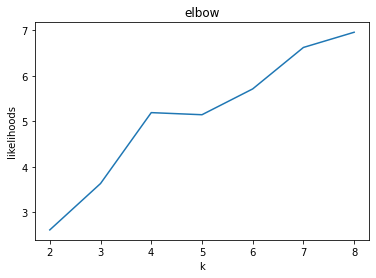

In [43]:
plt.plot(range(2,max_k+1),likelihoods)
plt.xlabel('k')
plt.ylabel('likelihoods')
plt.title('elbow')

In [44]:
threshold = np.matrix(.01)
k=4
Phi, Mu, Sigma = init_gmm(X, k)
converged = False
while not converged:
    converged, pj, X_label = iterate_em_gmm(X, threshold, Phi, Mu, Sigma)

In [45]:
print(Mu)

[[ 0.10258398 -0.20012497 -0.07065543  0.00955686]
 [ 0.15711201  0.12344046  0.02242276 -0.04547261]
 [-0.0509476  -0.00659923  0.0173797  -0.02506115]
 [-0.37078844  0.57103587  0.00524299 -0.05059213]
 [-0.2656319  -0.2656269   1.76853413 -0.26564501]
 [ 0.07095656  0.88221221 -0.04104014 -0.18843166]]


In [46]:
print(Sigma.shape)
print(Mu.shape)

(4, 6, 6)
(6, 4)


In [47]:
import sys
#np.set_printoptions(threshold=sys.maxsize)
print(Sigma.shape)
print(Mu.shape)
print(X.shape)

m_distance = np.zeros((X.shape[0],Mu.shape[1]))
m, n = X.shape
for kk in range(Mu.shape[1]):
# get all row data from target column
    mu = Mu[:, kk]
    # print('mu.shape',mu.shape)
    # get target sigma
    sig = Sigma[kk,:,:].reshape((n, n))
    # print('sig:',sig.shape)
    # inverse matrix of sigma
    sig_inv = np.linalg.inv(sig)
    # print('sig_inv',sig_inv.shape)
    # find difference of mu and x and reshape it (if need)
    for i, x in enumerate(X):
        diff = (x - mu).reshape(n, 1)
        distance = np.sqrt(diff.T @ sig_inv @ diff)
        m_distance[i,kk] = distance

# find unique of minimum m_distance and count
# hint: use np.unique and np.argmin
# (unique, counts) = None, None
unique = np.unique(m_distance)
max_z_score = 2.05
# find minimum distance
# hint: use np.min
min_distance = np.min(m_distance, axis=1)
# find outlier from min_distance
outlier = np.where(min_distance > max_z_score)
# YOUR CODE HERE
# raise NotImplementedError()

(4, 6, 6)
(6, 4)
(3920, 6)


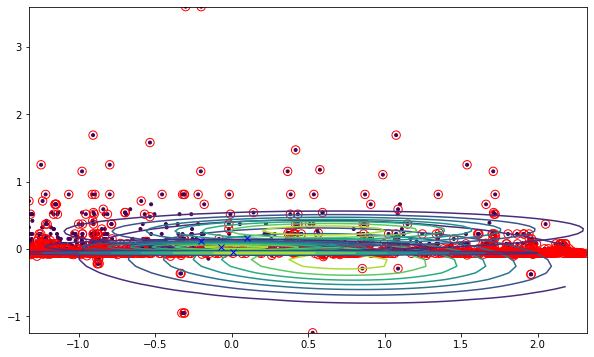

In [48]:
# print('outlier', outlier)
plt.figure(figsize=(10,6))
plt.scatter(X[:,0],X[:,1],marker=".",c=pj,cmap='viridis');
plt.scatter(X[outlier,0],X[outlier,1],marker="o",facecolor="none",edgecolor="r",s=70);
plt.plot(Mu[0,0], Mu[1,0],'bx',Mu[0,1], Mu[1,1],'bx', Mu[0,2], Mu[1,2],'bx', Mu[0,3], Mu[1
,3],'bx')
for c in np.arange(0,k):
    X_class = X[np.where(X_label[:,2] == c)[0],:]
    # print(X_class.shape)
    xlist = np.linspace(min(X_class[:,0]), max(X_class[:,0]), 50)
    ylist = np.linspace(min(X_class[:,1]), max(X_class[:,1]), 50)
    xlist1 = np.linspace(min(X_class[:,2]), max(X_class[:,2]), 50)
    ylist1 = np.linspace(min(X_class[:,3]), max(X_class[:,3]), 50)
    xlist2 = np.linspace(min(X_class[:,4]), max(X_class[:,4]), 50)
    ylist2 = np.linspace(min(X_class[:,5]), max(X_class[:,5]), 50)

    XX, YY = np.meshgrid(xlist, ylist)
    XX1, YY1 = np.meshgrid(xlist1, ylist1)
    XX2, YY2 = np.meshgrid(xlist2, ylist2)
    # print(XX.shape)
    Z = np.zeros(XX.shape)
    i = 0
    while i < XX.shape[0]:
        j = 0
        while j < XX.shape[0]:
            pt = np.array([ [XX[i,j], YY[i,j], XX1[i,j], YY1[i,j], XX2[i,j], YY2[i,j]] ])
            # print(pt)
            # print(pt.shape, Mu[:,c].shape)
            Z[i,j] = Gaussian(pt, Mu[:,c], Sigma[c])
            j = j + 1
        i = i + 1
    # cp = plt.contour(XX, YY, XX1, YY1, XX2, YY2, Z)
    cp = plt.contour(XX, YY, Z)
plt.show()

First, I find the likelihoods as a function of k. I selected the max_k as 8 and plot the elbow and I found out that
the elbow is around 4. So I decided to use 4 as the number of cluster. Then I run the GMM with Mahalanobis
distance threshold. I did not get a good plot in the graph because our dataset has 6 columns and we are trying to
plot in 2D

In [49]:
# from sklearn.preprocessing import StandardScaler
# sc = StandardScaler()
# data = sc.fit_transform(data)

In [50]:
# def iterate_em_gmm(X, threshold, Phi, Mu, Sigma):
#     m = X.shape[0]
#     n = X.shape[1]
#     k = len(Phi)
#     threshold = np.reshape(np.repeat(threshold, n*k), (n,k))
#     pj_arr = np.zeros((m,k))
    
#     # E-step: calculate w_j^i
#     W = np.zeros((m, k))
#     for j in range(k):
#         pj = Gaussian(X, Mu[:,j], Sigma[j,:,:])
#         pj_arr[:,j] = pj
#         W[:,j] = Phi[j] * pj
    
#     # W tells us what is the relative weight of each cluster for each data point
#     W[:,:] = W * np.tile(1/np.sum(W,1),(k,1)).T

#     # M-step: adjust mean and sigma
#     Phi[:] = sum(W) / m
#     Mu_previous = Mu.copy()
#     for j in range(k):
#         # Split cluster specific W for each dimension
#         Wj = np.tile(W[:,j],(n,1)).T
#         Wj = pd.DataFrame(Wj).fillna(0).values
        
# #         # Compute Mu for each variable for each cluster
# #         Mu[:,j] = sum(X * Wj)/sum(Wj)
#         Muj = np.tile(Mu[:,j],(m,1))
# #         Sigma[j,:,:] = np.matmul((X - Muj).T, (X - Muj) * Wj) / sum(W[:,j])
        
#          # Compute Mu for each variable for each cluster    
#         a = (X - Muj).T
#         b = (X - Muj) * Wj
#         a = pd.DataFrame(a).fillna(0)
#         b = pd.DataFrame(b).fillna(0)
#         Sigma[j,:,:] = a.dot(b).values / np.nansum(W[:,j])

#     if (abs(Mu-Mu_previous) <= threshold).all():
#         converged = True
#     else:
#         converged = False

#     labels = np.argmax(pj_arr, axis = 1)
#     #pj = pj_arr[np.arange(0,m,1),labels]
#     pj = np.max(pj_arr,axis=1)
#     X_label = np.insert(X, n, labels, axis=1)
#     return converged, pj, X_label
#     #return converged, pj, X_label, Phi, Mu, Sigma


In [51]:
# # print('outlier', outlier)
# plt.figure(figsize=(10,6))
# plt.scatter(X[:,0],X[:,1],marker=".",c=pj,cmap='viridis');

# plt.scatter(X[outlier,0],X[outlier,1],marker="o",facecolor="none",edgecolor="r",s=70);
# plt.plot(Mu[0,0], Mu[1,0],'bx',Mu[0,1], Mu[1,1],'bx', Mu[0,2], Mu[1,2],'bx', Mu[0,3], Mu[1,3],'bx')

# for c in np.arange(0,k):    
#     X_class = X[np.where(X_label[:,2] == c)[0],:]
#     # print(X_class.shape)
#     xlist = np.linspace(min(X_class[:,0]), max(X_class[:,0]), 50)
#     ylist = np.linspace(min(X_class[:,1]), max(X_class[:,1]), 50)
#     xlist1 = np.linspace(min(X_class[:,2]), max(X_class[:,2]), 50)
#     ylist1 = np.linspace(min(X_class[:,3]), max(X_class[:,3]), 50)
#     xlist2 = np.linspace(min(X_class[:,4]), max(X_class[:,4]), 50)
#     ylist2 = np.linspace(min(X_class[:,5]), max(X_class[:,5]), 50)
    
#     XX, YY = np.meshgrid(xlist, ylist)
#     XX1, YY1 = np.meshgrid(xlist1, ylist1)
#     XX2, YY2 = np.meshgrid(xlist2, ylist2)
#     # print(XX.shape)
#     Z = np.zeros(XX.shape)
#     i = 0
#     while i < XX.shape[0]:
#         j = 0
#         while j < XX.shape[0]:
#             pt = np.array([ [XX[i,j], YY[i,j], XX1[i,j], YY1[i,j], XX2[i,j], YY2[i,j]] ])
#             # print(pt)
#             # print(pt.shape, Mu[:,c].shape)
#             Z[i,j] = Gaussian(pt, Mu[:,c], Sigma[c])
#             j = j + 1
#         i = i + 1    
#     cp = plt.contour(XX, YY, Z)

# plt.show()


In [52]:
# # X  = np.array(data.copy(), dtype=float)
# # X = data.values.copy()
# X = data.copy()
# n = X.shape[1]
# m = X.shape[0]

# def cost(X_label, Mu):
#     loss = np.inf
#     for j in range(Mu.shape[1]) : 
#         Muj = Mu.T[j]
#         Xj = X_label[X_label[:, -1] == j][:, :-1]
#         loss = min(loss, np.min(np.linalg.norm(Xj-Muj, ord=2)))
#     return loss

# loss_log = []
# for k in range(2,10):

#     threshold = np.matrix(.01)

#     Phi, Mu, Sigma = init_gmm(X, k)

#     converged = False
#     while not converged:
#         #converged, pj, X_label, Phi, Mu, Sigma = iterate_em_gmm(X, 0.1, Phi, Mu, Sigma)
#         converged, pj, X_label = iterate_em_gmm(X, 0.1, Phi, Mu, Sigma)
    
#     loss = cost(X_label, Mu)
#     loss_log.append(loss)
    

In [53]:
# loss_log = np.array(loss_log)
# plt.figure(figsize=(16,8))
# plt.plot(loss_log)
# plt.xlabel('n cluster')
# plt.ylabel('Distortion')
# plt.title('Elbow Curve')
# plt.show()